# Dataset 2: Adult Income

This notebook presents a benchmark of three classification models on the
Adult Income dataset, followed by model explainability analysis and
counterfactual explanations for the best-performing model.

## Dataset description

The Adult Income dataset contains demographic and employment-related
information extracted from the 1994 U.S. Census database.

The task is a binary classification problem:
- 0 — income ≤ 50K USD
- 1 — income > 50K USD


In [41]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


-----

In [42]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

----

In [43]:
#LOAD DATA
adult = fetch_openml("adult", version=2, as_frame=True)

df = adult.frame

X = df.drop(columns="class")
y = (df["class"] == ">50K").astype(int)

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [44]:
# The dataset contains approximately 48,000 instances with a mixture of
# numerical and categorical features.
# The class distribution is imbalanced, with the majority of instances
# belonging to the income ≤ 50K class.

X.shape, y.value_counts()

((48842, 14),
 class
 0    37155
 1    11687
 Name: count, dtype: int64)

In [45]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

----

# Benchmark

In [46]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), num_features),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    verbose_feature_names_out=False
)


In [47]:
models = {
    "Logistic Regression": Pipeline([
        ("prep", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ("prep", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ]),
    "Gradient Boosting": Pipeline([
        ("prep", preprocessor),
        ("model", GradientBoostingClassifier(
            random_state=42
        ))
    ])
}

In [48]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name

'Gradient Boosting'

----

# XAI


## Feature importance


In [49]:
# Get feature names after preprocessing
feature_names = best_model.named_steps["prep"].get_feature_names_out()

importances = best_model.named_steps["model"].feature_importances_

feature_importance = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False)
)

feature_importance.head(10)

marital-status_Married-civ-spouse    0.396692
capital-gain                         0.195132
education-num                        0.193526
capital-loss                         0.057876
age                                  0.057321
hours-per-week                       0.032585
occupation_Exec-managerial           0.020738
occupation_Prof-specialty            0.008414
occupation_Other-service             0.005659
workclass_Self-emp-not-inc           0.004767
dtype: float64

## SHAP

In [50]:
# SHAP setup

X_test_transformed = best_model.named_steps["prep"].transform(X_test)

if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

X_test_transformed = X_test_transformed.astype(np.float64)

feature_names = best_model.named_steps["prep"].get_feature_names_out()
gb_model = best_model.named_steps["model"]

explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test_transformed)

shap_values

array([[ 3.26442571e-01,  2.06562516e-02, -3.75302700e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.39908541e-04],
       [-1.01488978e+00, -2.65071345e-03, -2.13979855e-01, ...,
         0.00000000e+00,  0.00000000e+00,  4.34728100e-04],
       [ 1.40718033e-01,  2.70155975e-02,  5.47845470e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.86174919e-04],
       ...,
       [ 5.64515128e-01,  4.60390317e-02, -3.71599316e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.86174919e-04],
       [-6.27832687e-01, -7.31849517e-02, -2.11120040e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.86174919e-04],
       [-1.13183712e+00, -5.49437924e-02, -1.59075797e-02, ...,
         0.00000000e+00,  0.00000000e+00,  1.39908541e-04]],
      shape=(12211, 108))

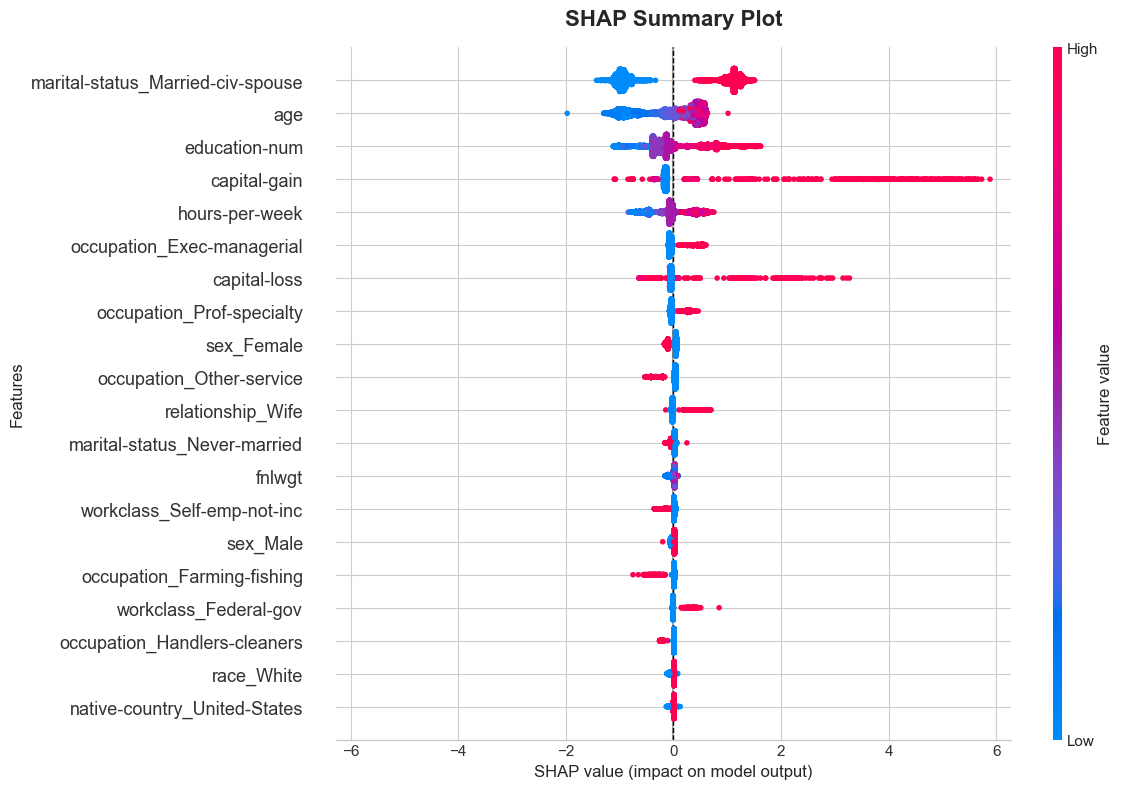

In [51]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()
ax.axvline(0, color="black", linestyle="--", linewidth=1)

max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)

plt.title(
    "SHAP Summary Plot",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()

## LIME

In [52]:
# LIME setup

X_train_lime = best_model.named_steps["prep"].transform(X_train)
X_test_lime = best_model.named_steps["prep"].transform(X_test)

if hasattr(X_train_lime, "toarray"):
    X_train_lime = X_train_lime.toarray()
    X_test_lime = X_test_lime.toarray()

X_train_lime = X_train_lime.astype(np.float64)
X_test_lime = X_test_lime.astype(np.float64)

lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    mode="classification",
    discretize_continuous=False
)

index = 0
instance = X_test_lime[index]
instance

array([-0.0512802 , -0.2908866 , -0.41882603, -0.14430696, -0.21976933,
       -0.0364775 ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.  

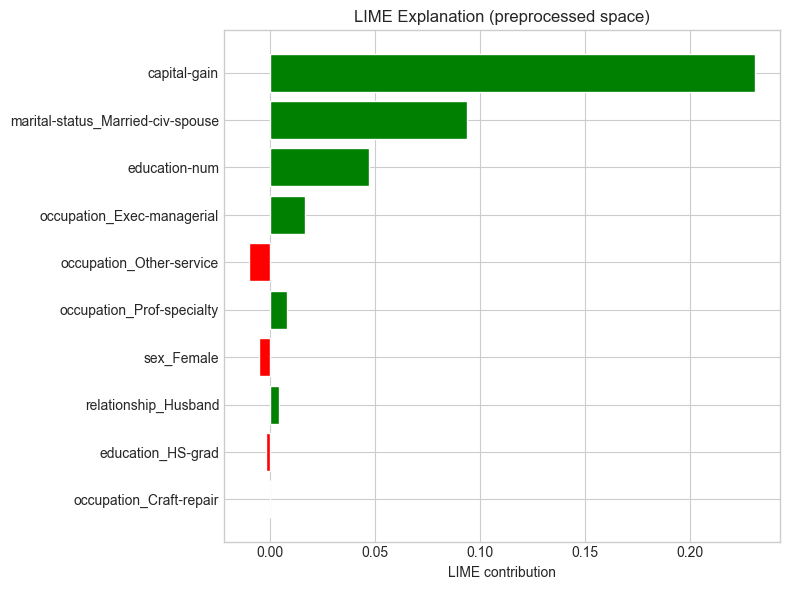

In [53]:
def predict_proba_model(x):
    return best_model.named_steps["model"].predict_proba(x)

lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba_model,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation (preprocessed space)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Counterfactual Explanations (DiCE)

In [54]:
#DiCE setup

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

df = X.copy()
df["target"] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=num_features,
    categorical_features=cat_features,
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = X_test.iloc[[0]]
query_instance

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
44696,38,Private,159179,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States


In [55]:
dice.generate_counterfactuals(
    query_instance,
    features_to_vary=[
        f for f in num_features if f != "fnlwgt"
    ],
    total_CFs=3,
    desired_class=1
)

dice_exp = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=1
)

dice_exp.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,38,Private,159179,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,38,Private,159179,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,10538,683,40,United-States,1
1,38,Private,159179,HS-grad,11,Married-civ-spouse,Craft-repair,Husband,White,Male,94187,0,40,United-States,1
2,38,Never-worked,159179,HS-grad,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1


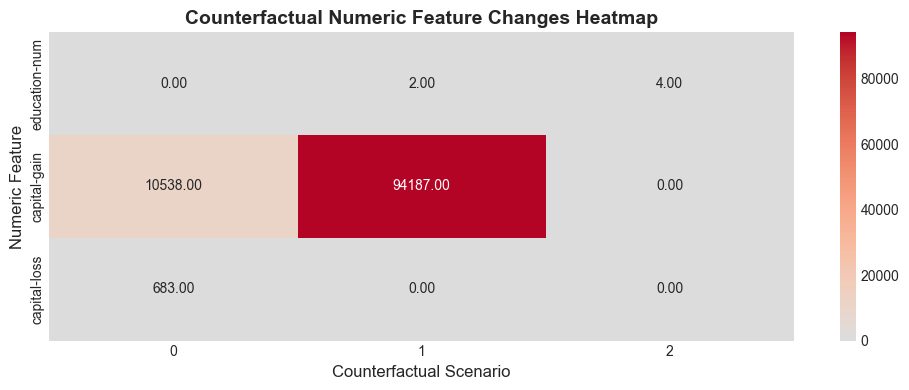

In [56]:
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
original = query_instance.iloc[0]

#ONLY numeric features
numeric_cols = num_features
original_num = pd.DataFrame(
    [original[numeric_cols].values] * len(cf_df),
    columns=numeric_cols
)

diff_num = cf_df[numeric_cols] - original_num
diff_changed = diff_num.loc[:, (diff_num != 0).any(axis=0)]


plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Numeric Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Numeric Feature", fontsize=12)

plt.tight_layout()
plt.show()


----

## Evaluation

#### VALIDITY

In [57]:
desired_class = 1


In [58]:
#filter target
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
cf_X = cf_df.drop(columns=["target"])


pre = best_model.named_steps["prep"]
clf = best_model.named_steps["model"]
orig = query_instance.iloc[0][cf_X.columns]
cf_pre = pre.transform(cf_X)

validity = clf.predict(cf_pre) == desired_class

validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_X))],
    "Validity": validity
})

validity_df

,Counterfactual,Validity
0,CF_0,True
1,CF_1,True
2,CF_2,True


#### SPARSITY

In [59]:
sparsity = (cf_X != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_X))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df

,Counterfactual,Sparsity (number of features changed)
0,CF_0,2
1,CF_1,2
2,CF_2,2


#### PROXIMITY


In [60]:
orig_df = query_instance.iloc[0][cf_X.columns].to_frame().T
orig_pre = pre.transform(orig_df)
cf_pre_dense = cf_pre.toarray()
orig_pre_dense = orig_pre.toarray()
orig_repeated = np.repeat(orig_pre_dense, cf_pre_dense.shape[0], axis=0)
l1_distance = np.abs(cf_pre_dense - orig_repeated).sum(axis=1)

proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df

,Counterfactual,Proximity (L1 distance)
0,CF_0,3.105800
1,CF_1,13.537744
2,CF_2,3.553897


#### PLAUSIBILITY

In [61]:
num_cols = cf_X.select_dtypes(include=["int64", "float64"]).columns
common_cols = num_cols.intersection(X.columns)

X_num = X[common_cols]

def plausible(cf_row, X_num):
    return ((cf_row >= X_num.min()) & (cf_row <= X_num.max())).all()

plausibility = cf_X[common_cols].apply(
    lambda row: plausible(row, X_num),
    axis=1
)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df


,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True


The generated counterfactual explanations were evaluated using validity, sparsity, proximity, and plausibility metrics.
All counterfactuals successfully flipped the model prediction to the desired class, resulting in a validity score of 100%.

Sparsity analysis showed that only one or two input features needed to be changed, indicating concise and interpretable counterfactual explanations.
Proximity, measured using L1 distance over numerical features, revealed noticeable variation between counterfactuals, largely influenced by features with a larger numerical scale.

Plausibility analysis confirmed that all counterfactuals remained within the observed data ranges, ensuring consistency with the training distribution.
Overall, the results suggest a stable decision boundary, where multiple low-complexity and valid counterfactual paths exist for changing the model outcome.